In [1]:
import numpy as np 
from qiskit import QuantumRegister, ClassicalRegister,QuantumCircuit, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from Hamming import *
import qiskit
%matplotlib inline

In [2]:
def num_to_binary(n,N):
    # n is the number to be represented in binary
    # N is the number of digits of the rapresentation
    #es: num_to_binary(5,4) = 0101
    Nbits=2**N
    if n>=Nbits: return 0
    return bin(n+2*Nbits)[4:]


def HammingCircuit(N,ClassicalRegisters=None,ancillas=1):
    """
    -Returns a circuit with just the qbits labeled as the parity and signal
    -it gives you a circuit with 2^N qbits of (message + redundancy)
    -it can have classical registers if you want set ClassicalRegisters=True, if given a int "n" it will have 
    n classical registers
    by default it will have N ancillas, if specified it will have a numer N*ancillas"""
    registers=[]
    for i in range(2**N):
        prefix='s' #s stands for signal
        if i==0 or np.log2(i)==int(np.log2(i)): prefix='p' #c stands for parity
        registers.append(QuantumRegister(1,prefix+num_to_binary(i, N)))
    if ClassicalRegisters!=None: 
        if ClassicalRegisters==True: registers.append(ClassicalRegister(2**N+N*ancillas))
        else: registers.append(ClassicalRegister(ClassicalRegisters))
    circuit=QuantumCircuit(*registers,QuantumRegister(N*ancillas,'anc')) #circuit already with ancillas
    #circit=QuantumCircuit(*registers)
    circuit.N=N
    return circuit


def xor(N):
    #This is the gate that calculates the xor of all the position with ones, this gives the position of the faulty qbit
    circ=HammingCircuit(N)
    nqubits=2**N
    for i in range(1,nqubits):
        for j in range(0,N):
            if i & 2**j == 2**j: circ.cx(i,nqubits+j)
    return circ.to_gate(label='Initialize')

def correct(N):
    #This is the gate that corrects the faulty qbit
    circ=HammingCircuit(N)
    nqubits=2**N
    count=np.zeros(N)
    for i in range(1,nqubits):
        count=count+1
        for j in range(N):
            count[j]=count[j]%(2**j)
            if count[j]==0 and i!=1: circ.x(nqubits+j)
            if i==1 and j!=0: circ.x(nqubits+j)
        circ.mct([*range(nqubits,nqubits+N)],i)
    return circ.to_gate(label='Correction')

def HammingGate0(N):
    #Hamming Gate resistant to bit-fips
    circ=HammingCircuit(N)
    circ.append(xor(N),[*range(2**N+N)])
    circ.append(correct(N),[*range(2**N+N)])
    return circ.to_gate(label='Hamming0')

def HammingRedundant(n):
    #Takes a integer "n" and makes the binary representation of that integer hamming redundant
    bits=int(np.log2(n))+1
    parity=int(np.log2(bits))+2
    total=2**(parity)
    N,j=0,0
    #shift the digits in the correct positions for the hamming code
    for i in range(total):
        if i!=0 and int(np.log2(i))!=np.log2(i):
            N=N+(n&(2**j)==2**j)*(2**i)
            j=j+1
    #puts the parity bit in place except for the global parity bit
    for i in range(parity):
        i=2**i
        for j in range(i,total):
            N=N^((2**i)*((j&i==i)&((N&2**j)!=0)))
    #Global parity bit (yet to be tested)
    #for i in range(1,total):N=N^((N&2**i)==1)
    return N

def classic_input(n,N=None):
    #n is the number in integer format, N is the size of the gate
    #doesn't work and i 
    if N==None: N=int(np.log2(n))+1
    if (n>=2**N): raise 'ma sei trimò'
    registers=QuantumRegister(N)
    circuit=QuantumCircuit(registers)
    for i in range(N):
        j=2**i
        if (n&j)==j: circuit.x(i)
    return circuit.to_gate(num_to_binary(n,N))

In [3]:
N=3


def HammingCorrection(N):
    circuit=HammingCircuit(N,ancillas=2)
    Ham_0=HammingGate0(N)
    #circuit.h([*range(2**N)])
    circuit.append(Ham_0,[*range(2**N+N)])
    circuit.h([*range(2**N)])
    circuit.append(Ham_0,[*range(2**N),*range(2**N+N,2**N+2*N)])
    return circuit.to_gate(label='Hamming Correction')

In [4]:
N = 3
circuit=HammingCircuit(N, True, ancillas=2)
enc=bit_phase_encoder(N)
circuit.append(enc,[*range(2**N)])


asd=HammingCorrection(N)
circuit.append(asd,[*range(2**N+2*N)])
circuit.measure([*range(2**N)],[*range(2**N)])


circuit.draw()

┌────────────────────┐┌──────────────────────┐┌─┐                     
p000_0: ┤0                   ├┤0                     ├┤M├─────────────────────
        │                    ││                      │└╥┘┌─┐                  
p001_0: ┤1                   ├┤1                     ├─╫─┤M├──────────────────
        │                    ││                      │ ║ └╥┘┌─┐               
p010_0: ┤2                   ├┤2                     ├─╫──╫─┤M├───────────────
        │                    ││                      │ ║  ║ └╥┘┌─┐            
s011_0: ┤3                   ├┤3                     ├─╫──╫──╫─┤M├────────────
        │  bit phase encoder ││                      │ ║  ║  ║ └╥┘┌─┐         
p100_0: ┤4                   ├┤4                     ├─╫──╫──╫──╫─┤M├─────────
        │                    ││                      │ ║  ║  ║  ║ └╥┘┌─┐      
s101_0: ┤5                   ├┤5                     ├─╫──╫──╫──╫──╫─┤M├──────
        │                    ││                      │ ║  ║  ║  ║  ║ └╥┘┌─┐   
s110_0: ┤6                   ├┤6                     ├─╫──╫──╫──╫──╫──╫─┤M├───
        │                    ││   Hamming Correction │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
s111_0: ┤7                   ├┤7                     ├─╫──╫──╫──╫──╫──╫──╫─┤M├
        └────────────────────┘│                      │ ║  ║  ║  ║  ║  ║  ║ └╥┘
 anc_0: ──────────────────────┤8                     ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_1: ──────────────────────┤9                     ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_2: ──────────────────────┤10                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_3: ──────────────────────┤11                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_4: ──────────────────────┤12                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_5: ──────────────────────┤13                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
                              └──────────────────────┘ ║  ║  ║  ║  ║  ║  ║  ║ 
 c0: 14/═══════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                                       0  1  2  3  4  5  6  7

In [10]:
simulator = Aer.get_backend("qasm_simulator")
result = qiskit.execute(circuit, backend = simulator, shots=1000).result()

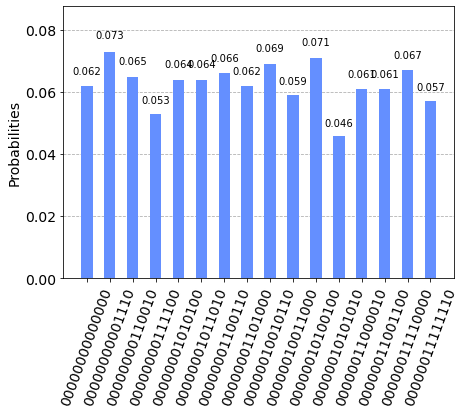

In [11]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In [6]:
circuit=HammingCircuit(N,ancillas=2)
Ham_0=HammingGate0(N)
#circuit.h([*range(2**N)])
circuit.append(Ham_0,[*range(2**N+N)])
circuit.h([*range(2**N)])
circuit.append(Ham_0,[*range(2**N),*range(2**N+N,2**N+2*N)])


circuit.draw()

CircuitError: 'Index out of range.'

In [10]:
HammingCorrection(3).()

AttributeError: 'Gate' object has no attribute 'draw'

In [8]:
simulator = QasmSimulator()

In [9]:
N=3
n_correct=HammingRedundant(13)
circuit=HammingCircuit(N,True,2)
flipped_bit=0#2**2
n_wrong=n_correct^flipped_bit
for i in range(2**N):
        j=2**i
        if (n_wrong&j)==j: circuit.x(i)
asd=HammingCorrection(N)
circuit.append(asd,[*range(2**N+2*N)])
circuit.measure([*range(2**N)],[*range(2**N)])
circuit.draw()

┌──────────────────────┐┌─┐                     
p000_0: ─────┤0                     ├┤M├─────────────────────
             │                      │└╥┘┌─┐                  
p001_0: ─────┤1                     ├─╫─┤M├──────────────────
        ┌───┐│                      │ ║ └╥┘┌─┐               
p010_0: ┤ X ├┤2                     ├─╫──╫─┤M├───────────────
        ├───┤│                      │ ║  ║ └╥┘┌─┐            
s011_0: ┤ X ├┤3                     ├─╫──╫──╫─┤M├────────────
        └───┘│                      │ ║  ║  ║ └╥┘┌─┐         
p100_0: ─────┤4                     ├─╫──╫──╫──╫─┤M├─────────
             │                      │ ║  ║  ║  ║ └╥┘┌─┐      
s101_0: ─────┤5                     ├─╫──╫──╫──╫──╫─┤M├──────
        ┌───┐│                      │ ║  ║  ║  ║  ║ └╥┘┌─┐   
s110_0: ┤ X ├┤6                     ├─╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤│   Hamming Correction │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
s111_0: ┤ X ├┤7                     ├─╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘│                      │ ║  ║  ║  ║  ║  ║  ║ └╥┘
 anc_0: ─────┤8                     ├─╫──╫──╫──╫──╫──╫──╫──╫─
             │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_1: ─────┤9                     ├─╫──╫──╫──╫──╫──╫──╫──╫─
             │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_2: ─────┤10                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
             │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_3: ─────┤11                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
             │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_4: ─────┤12                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
             │                      │ ║  ║  ║  ║  ║  ║  ║  ║ 
 anc_5: ─────┤13                    ├─╫──╫──╫──╫──╫──╫──╫──╫─
             └──────────────────────┘ ║  ║  ║  ║  ║  ║  ║  ║ 
 c0: 14/══════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                      0  1  2  3  4  5  6  7

In [87]:
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts(circuit)
print('input',num_to_binary(n_wrong,2**N))
print('output',counts)
print('dovrebbe essere',num_to_binary(n_correct,2**N))

input 11001100
output {'00000010100101': 25, '00000000001110': 25, '00000011110001': 29, '00000001101000': 34, '00000000111101': 32, '00000011111110': 31, '00000011110000': 39, '00000011000010': 25, '00000010010111': 41, '00000010101010': 43, '00000000110010': 31, '00000000000001': 27, '00000011001101': 24, '00000000001111': 28, '00000001100110': 31, '00000010011001': 26, '00000010011000': 46, '00000010010110': 30, '00000000111100': 30, '00000011001100': 34, '00000011111111': 38, '00000001010101': 37, '00000001011010': 30, '00000001010100': 27, '00000011000011': 30, '00000010100100': 28, '00000001011011': 34, '00000001100111': 30, '00000000110011': 29, '00000010101011': 30, '00000000000000': 28, '00000001101001': 28}
dovrebbe essere 11001100
